# ITALY COVID-19 DATA ANALYSIS

In this jupyter notebook, we'll try analyse italian COVID-19 data gathered from *Dipartimento di Protezione Civile* GitHub repository ([link](https://github.com/pcm-dpc/COVID-19)).

We'll first create $x$ axes with datetime objects and $y$ axes with daily variations of
- confirmed cases
- recoveries
- deaths
- infected

where _infected_ are equal to _confirmed - (recoverd + deaths)_.

We won't reject outliers not loose any data, nor standardize or normalize data but we'll try to work with rough data only fitting them to gaussian curves (prime derivatives of the logistic growth curves) and to a gaussian derivative for infected curve and try to get a forecast up to as many days as the period covered by gathered data.

In [3]:
%matplotlib notebook

import json
import requests
import datetime as dt

from IPython.display import display, Math, Latex

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import numpy as np

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

First, let's define the gaussian function we'll use to fit data $$y = a \mathbf{e}^{ -(x-b)^2 / c^2}$$

In [4]:
def gauss_func(x, a, b, c):
    d = - ((x - b) ** 2)
    return a * np.exp( d / (c ** 2) )

And the gaussian derivative we'll use for infected $$ \frac{\partial }{\partial x}\left ( a \mathbf{e}^{ -(x-b)^2 / c^2} \right ) =
- 2a(x-b) \frac{ \mathbf{e}^{ -(b - x)^2 / c^2 } }{ c^2 } $$

In [5]:
def gauss_diff_func(x, a, b, c):
    d = (- ((b - x) ** 2)) / (c ** 2)
    u = - 2 * a * (x - b)
    return u * np.exp(d) / (c ** 2)

and get the most recently updated data from D.P.C. GitHub repository, loading them into a dictionary:

In [6]:
json_ita = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json"
with requests.get(json_ita) as req:
    data = json.loads(req.content.decode('utf-8-sig'))

Let's check the dates of the downloaded data:

In [7]:
print("FIRST ENTRY DATE: {}".format(data[0]["data"].replace("T", " ")))

print("LAST  ENTRY DATE: {}".format(data[-1]["data"].replace("T", " ")))

period = (
    dt.datetime.strptime(data[-1]["data"], "%Y-%m-%dT%H:%M:%S") -
    dt.datetime.strptime(data[0]["data"], "%Y-%m-%dT%H:%M:%S")
).days

print("COVERAGE: {} days".format(period))

FIRST ENTRY DATE: 2020-02-24 18:00:00
LAST  ENTRY DATE: 2020-04-02 17:00:00
COVERAGE: 37 days


Now, let's initialize $x$ and $y$ variables (we'll need also integer $x$ array to perform `curve_fit`)

In [8]:
x = []   # datetime x array
_x = []  # integer x array
yC = []  # new confirmed cases array
yD = []  # new deaths array
yR = []  # new recovered array
yP = []  # new infected array

ynC = []  # total confirmed
ynD = []  # total deaths
ynR = []  # total recovered
ynP = []  # total infected

For each data entry:
- append datetime object to `x`
- append integer to `_x`
- append new cases to $y$

We'll skip `data[0]` and get the first difference from `data[1]` on

In [9]:
for i, day in enumerate(data):
    if not i:
        pre = day
        continue
    date = dt.datetime.strptime(day["data"], "%Y-%m-%dT%H:%M:%S")
    # x values
    x.append(date)
    _x.append(i)
    # y values
    yC.append(day["totale_casi"] - pre["totale_casi"])
    yD.append(day["deceduti"] - pre["deceduti"])
    yR.append(day["dimessi_guariti"] - pre["dimessi_guariti"])
    yP.append(day["variazione_totale_positivi"])
    
    pre = day

Let's take a look to gathered data

<IPython.core.display.Javascript object>


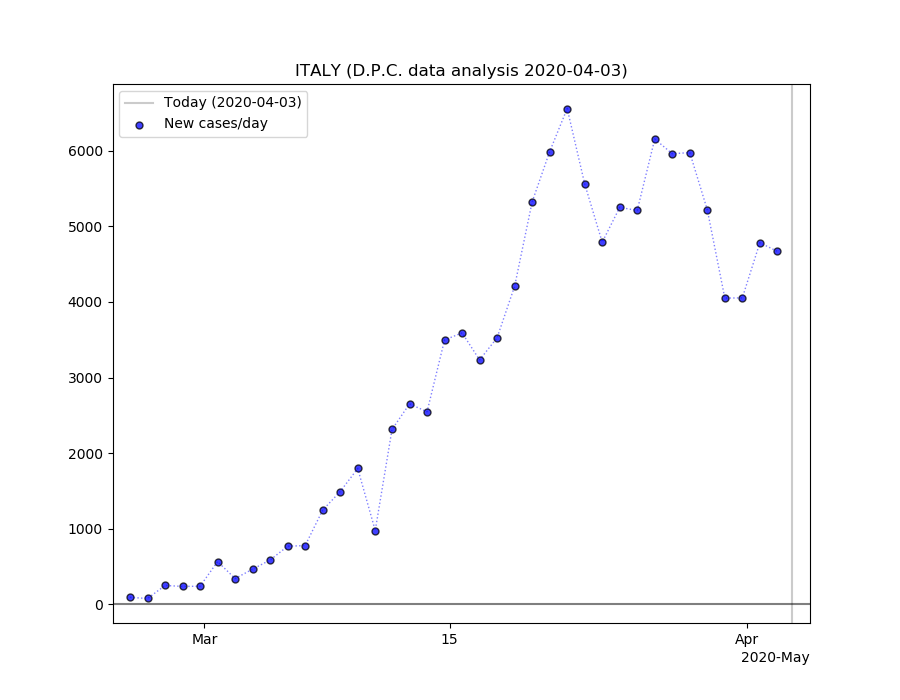

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(x[0] - dt.timedelta(days=1), max(x[-1], dt.datetime.now()) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yC, alpha=0.75, c="#0000ff",edgecolors='#000000', marker="o", s=25, label="New cases/day")
# original data dotted line
ax.plot(x, yC, alpha=0.5, c="b", linestyle=":", linewidth=1.0)


# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper left', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


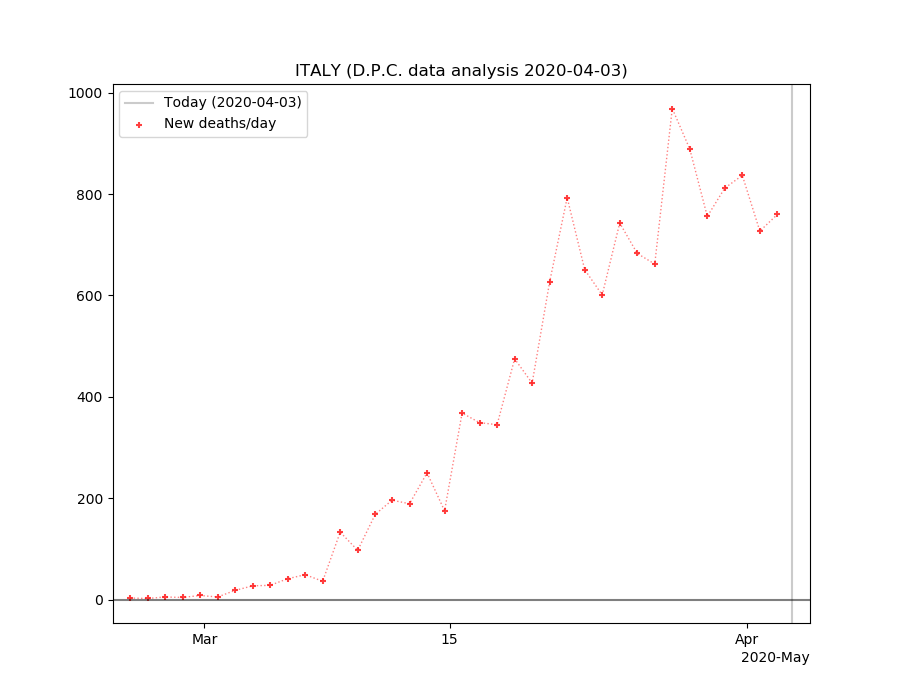

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(x[0] - dt.timedelta(days=1), max(x[-1], dt.datetime.now()) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yD, alpha=0.75, c="r",edgecolors='#000000', marker="+", s=25, label="New deaths/day")
# original data dotted line
ax.plot(x, yD, alpha=0.5, c="r", linestyle=":", linewidth=1.0)


# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper left', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


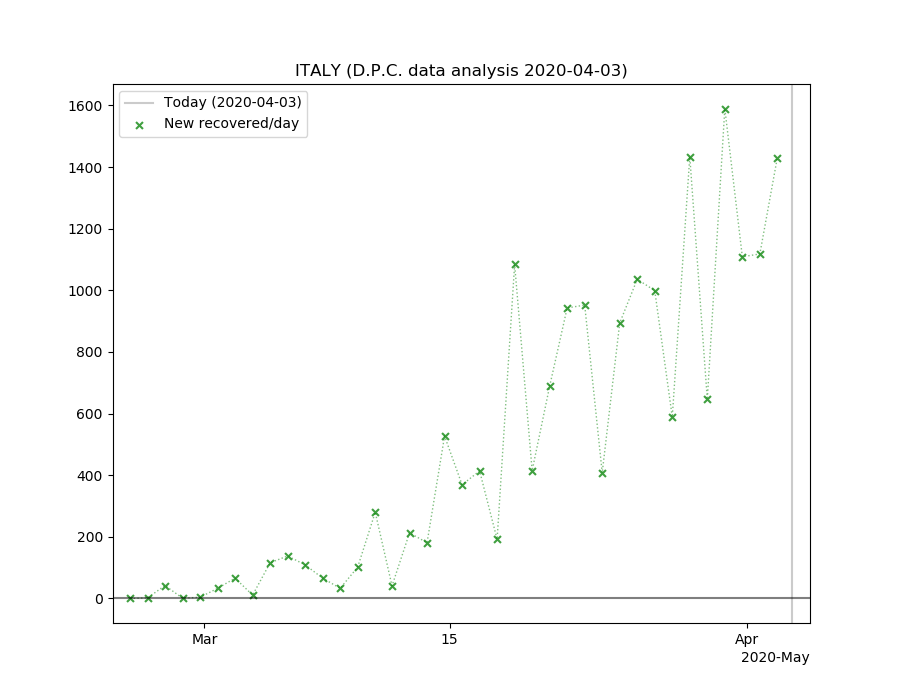

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(x[0] - dt.timedelta(days=1), max(x[-1], dt.datetime.now()) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yR, alpha=0.75, c="g",edgecolors='#000000', marker="x", s=25, label="New recovered/day")
# original data dotted line
ax.plot(x, yR, alpha=0.5, c="g", linestyle=":", linewidth=1.0)


# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper left', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


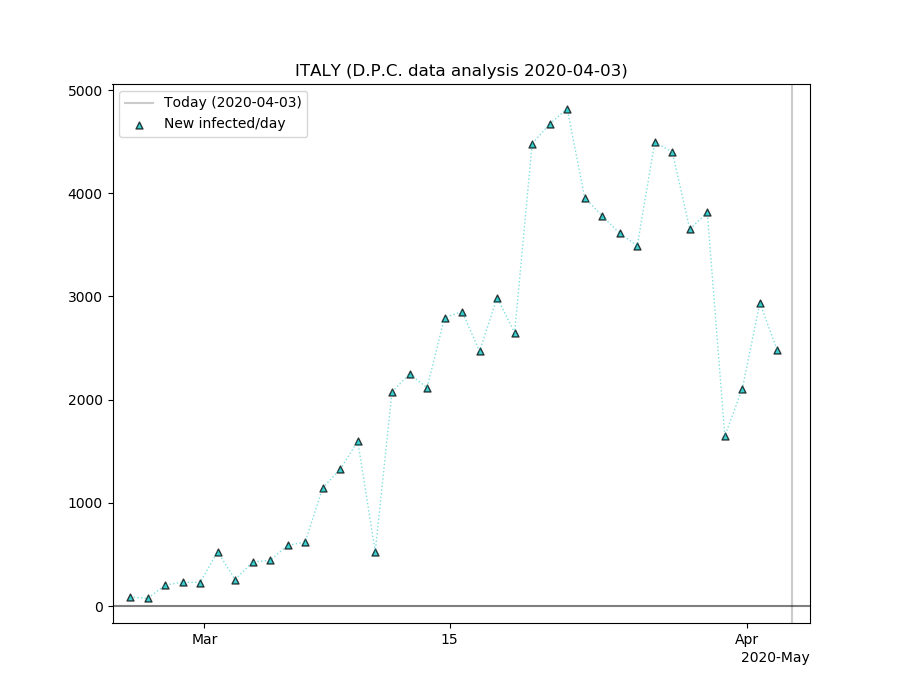

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(x[0] - dt.timedelta(days=1), max(x[-1], dt.datetime.now()) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yP, alpha=0.75, c="c",edgecolors='#000000', marker="^", s=25, label="New infected/day")
# original data dotted line
ax.plot(x, yP, alpha=0.5, c="c", linestyle=":", linewidth=1.0)


# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper left', fontsize='medium')
plt.show()

Let's now perform the `curve_fit` to the gaussian function with the known values (using integer array values `_x` instead of datetime `x`) to get `popt = (a, b, c)` parameters for each curve, guessing the maximum value of $y$ for $a$ parameter.
We'll also want get the `pcov` covariance of the fitted parameters and calculate the standard error `perr` we'll use later to plot standard error bands.

In [29]:
poptC, pcovC = curve_fit(gauss_func, _x, yC, p0=[max(yC), 1, 1])  # returns (a, b, c)
perrC = np.sqrt(np.diag(pcovC))
eSupC = poptC + perrC
eInfC = poptC - perrC

poptD, pcovD = curve_fit(gauss_func, _x, yD, p0=[max(yD), 1, 1])  # returns (a, b, c)
perrD = np.sqrt(np.diag(pcovD))
eSupD = poptD + perrD
eInfD = poptD - perrD

poptR, pcovR = curve_fit(gauss_func, _x, yR, p0=[max(yR), 1, 1])  # returns (a, b, c)
perrR = np.sqrt(np.diag(pcovR))
eSupR = poptR + perrR
eInfR = poptR - perrR

poptP, pcovP = curve_fit(gauss_diff_func, _x, yP, p0=[max(yP), _x[-1], 1])  # returns (a, b, c)
perrP = np.sqrt(np.diag(pcovP))
eSupP = poptP + perrP
eInfP = poptP - perrP

Here's what we found out

In [15]:
print("CONFIRMED")

display(Math(r"$a={:.2f} \pm {:.2f}$".format(poptC[0], perrC[0])))
display(Math(r"$b={:.2f} \pm {:.2f}$".format(poptC[1], perrC[1])))
display(Math(r"$c={:.2f} \pm {:.2f}$".format(abs(poptC[2]), perrC[2])))

CONFIRMED


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [16]:
print("DEATHS")

display(Math(r"$a={:.2f} \pm {:.2f}$".format(poptD[0], perrD[0])))
display(Math(r"$b={:.2f} \pm {:.2f}$".format(poptD[1], perrD[1])))
display(Math(r"$c={:.2f} \pm {:.2f}$".format(abs(poptD[2]), perrD[2])))

DEATHS


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [17]:
print("RECOVERED")

display(Math(r"$a={:.2f} \pm {:.2f}$".format(poptR[0], perrR[0])))
display(Math(r"$b={:.2f} \pm {:.2f}$".format(poptR[1], perrR[1])))
display(Math(r"$c={:.2f} \pm {:.2f}$".format(abs(poptC[2]), perrR[2])))

RECOVERED


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [30]:
print("INFECTED")

display(Math(r"$a={:.2f} \pm {:.2f}$".format(poptP[0], perrP[0])))
display(Math(r"$b={:.2f} \pm {:.2f}$".format(poptP[1], perrP[1])))
display(Math(r"$c={:.2f} \pm {:.2f}$".format(poptP[2], perrP[2])))

INFECTED


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let's now prepare `xg` array (datetime objects) and `_xg` array (integer values) for the forecast. We'll forecast for as many days of gathered data `period`, from the last day `x[-1]`.

In [19]:
print("Forecast up to: {}".format(x[-1] + dt.timedelta(days=period + 1)))

# forecast x datetime objects
xg = [x[-1] + dt.timedelta(days=d + 1) for d in range(period)]
xg = x + xg
# forecast x integer values
_xg = [_x[-1] + d + 1 for d in range(period)]
_xg = _x + _xg

Forecast up to: 2020-05-10 17:00:00


Let's get the values of $y$ of the gaussian curves and thier superior/inferior standard error, till the end of the forecast.

In [32]:
yCg = gauss_func(_xg, *poptC)
yCgSup = gauss_func(_xg, *eSupC)
yCgInf = gauss_func(_xg, *eInfC)

yDg = gauss_func(_xg, *poptD)
yDgSup = gauss_func(_xg, *eSupD)
yDgInf = gauss_func(_xg, *eInfD)

yRg = gauss_func(_xg, *poptR)
yRgSup = gauss_func(_xg, *eSupR)
yRgInf = gauss_func(_xg, *eInfR)

yPg = gauss_diff_func(_xg, *poptP)
yPgSup = gauss_diff_func(_xg, *eSupP)
yPgInf = gauss_diff_func(_xg, *eInfP)

Let's take a look to fitted gaussian curves with standard error bands

<IPython.core.display.Javascript object>


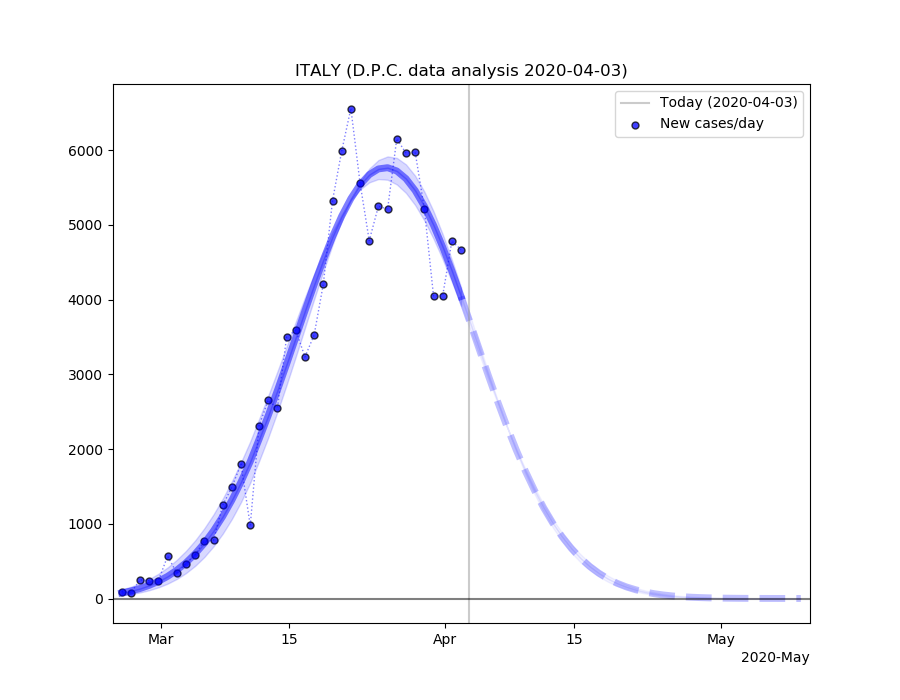

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

# original data points
ax.scatter(x, yC, alpha=0.75, c="b",edgecolors='#000000', marker="o", s=25, label="New cases/day")
# original data dotted line
ax.plot(x, yC, alpha=0.5, c="b", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yCg[:len(x)], alpha=0.5, c="b", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yCg[len(x) - 1:], alpha=0.25, c="b", linestyle="--", linewidth=5.0)

ax.fill_between(xg[:len(x)], yCg[:len(x)], yCgSup[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], yCg[len(x) - 1:], yCgSup[len(x) - 1:], alpha=0.05, color="b")
ax.fill_between(xg[:len(x)], yCg[:len(x)], yCgInf[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], yCg[len(x) - 1:], yCgInf[len(x) - 1:], alpha=0.05, color="b")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


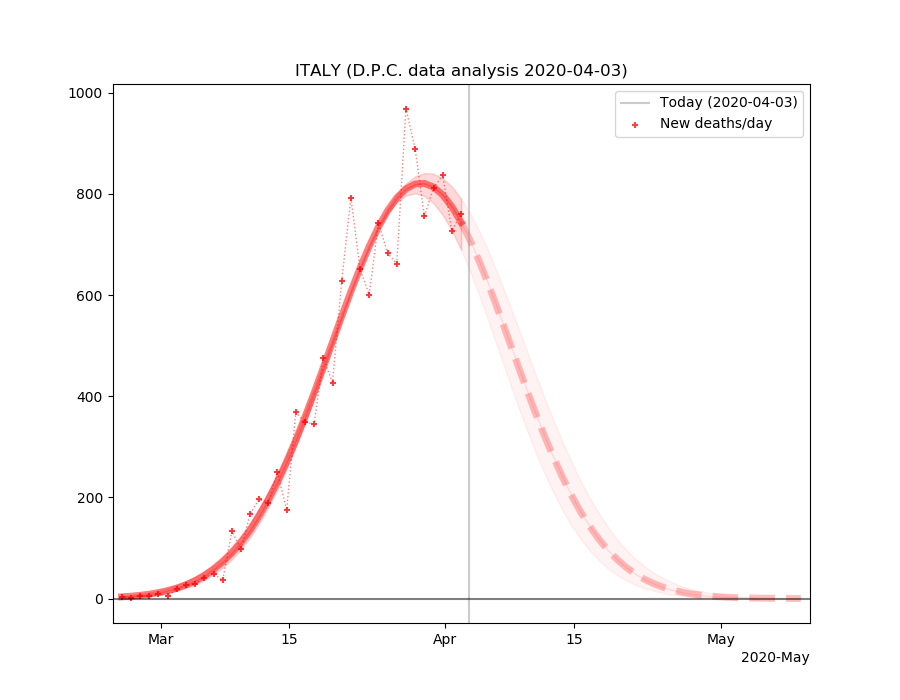

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

# original data points
ax.scatter(x, yD, alpha=0.75, c="r",edgecolors='#000000', marker="+", s=25, label="New deaths/day")
# original data dotted line
ax.plot(x, yD, alpha=0.5, c="r", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yDg[:len(x)], alpha=0.5, c="r", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yDg[len(x) - 1:], alpha=0.25, c="r", linestyle="--", linewidth=5.0)

ax.fill_between(xg[:len(x)], yDg[:len(x)], yDgSup[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], yDg[len(x) - 1:], yDgSup[len(x) - 1:], alpha=0.05, color="r")
ax.fill_between(xg[:len(x)], yDg[:len(x)], yDgInf[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], yDg[len(x) - 1:], yDgInf[len(x) - 1:], alpha=0.05, color="r")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


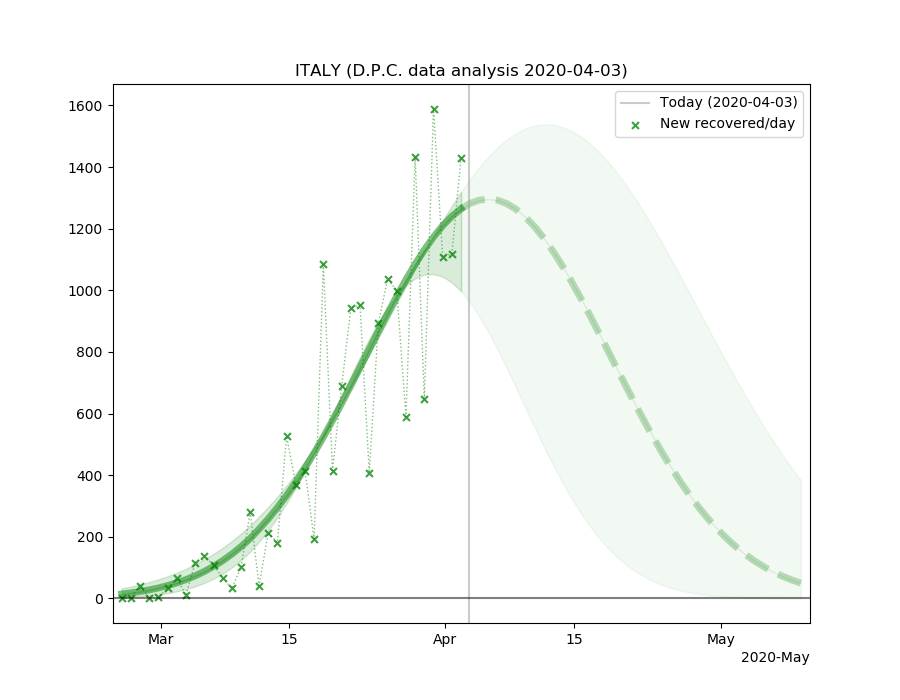

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

# original data points
ax.scatter(x, yR, alpha=0.75, c="g",edgecolors='#000000', marker="x", s=25, label="New recovered/day")
# original data dotted line
ax.plot(x, yR, alpha=0.5, c="g", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yRg[:len(x)], alpha=0.5, c="g", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yRg[len(x) - 1:], alpha=0.25, c="g", linestyle="--", linewidth=5.0)

ax.fill_between(xg[:len(x)], yRg[:len(x)], yRgSup[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], yRg[len(x) - 1:], yRgSup[len(x) - 1:], alpha=0.05, color="g")
ax.fill_between(xg[:len(x)], yRg[:len(x)], yRgInf[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], yRg[len(x) - 1:], yRgInf[len(x) - 1:], alpha=0.05, color="g")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')
plt.show()

<IPython.core.display.Javascript object>


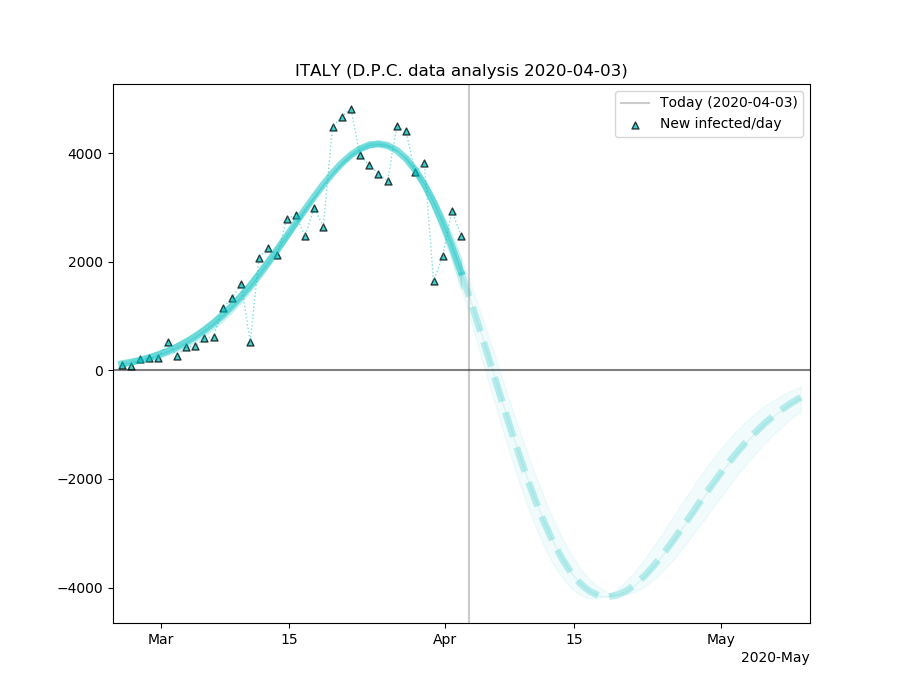

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), xg[-1] + dt.timedelta(days=1))

# original data points
ax.scatter(x, yP, alpha=0.75, c="c",edgecolors='#000000', marker="^", s=25, label="New infected/day")
# original data dotted line
ax.plot(x, yP, alpha=0.5, c="c", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yPg[:len(x)], alpha=0.5, c="c", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yPg[len(x) - 1:], alpha=0.25, c="c", linestyle="--", linewidth=5.0)

ax.fill_between(xg[:len(x)], yPg[:len(x)], yPgSup[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], yPg[len(x) - 1:], yPgSup[len(x) - 1:], alpha=0.05, color="c")
ax.fill_between(xg[:len(x)], yPg[:len(x)], yPgInf[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], yPg[len(x) - 1:], yPgInf[len(x) - 1:], alpha=0.05, color="c")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='medium')
plt.show()

For each $y$ array, let's now get
- the maximum $[x_{max}, y_{max}]$ coordinates and its standard error
  - in the standard gaussian curve, maximum coordinates are $[\mu, f(\mu)]$, in our gaussian function will then be $[b, f(b)]$ so we need to add $b - 1$ days to first $x_0$ date ($b - 1$ and not $b$ because we skeepped $x_0$) and calculate $y_{max} = f(b)$ with known parameters $(a, b, c)$
- the flexes $[x_{flex}, y_{flex}]$ coordinates and their standard error
  - the two flexes will obiviously be $[b-\sigma, f(b-\sigma)]$ and $[b+\sigma, f(b+\sigma)]$, so we first need to calculate $\sigma$ (the standard deviation):
    - $\sigma$ in our gaussian curve is equal to $c/\sqrt{2}$
- the guessed _~0 events/day_ and its standard error i.e. the day we could expect to have _almost_ no new event per day. We could choose this day as $\mu$ (the maximum, $b$) + three standard deviations $x_{0 cases} = b + 3\sigma$

In [34]:
# CONFIRMED CASES
a, b, c = poptC
aSup, bSup, cSup = poptC + perrC
aInf, bInf, cInf = poptC - perrC
# the maximum x coordinate, datetime object
muC = x[0] + dt.timedelta(days=abs(b) - 1)
muCsup = x[0] + dt.timedelta(days=abs(bSup) - 1)
muCinf = x[0] + dt.timedelta(days=abs(bInf) - 1)
# the maximum x coordinate, integer value
_muC = _xg[0] + abs(b) - 1
# the maximum y coordinate, given (a, b, c) = popt values
ymuC = gauss_func(_muC, *poptC)
# calculate sigma
siC = abs(c / np.sqrt(2))
siCsup = abs(cSup / np.sqrt(2))
siCinf = abs(cInf / np.sqrt(2))
# 1st flex coordinates
f1C = muC - dt.timedelta(days=siC)
f1Csup = muCsup - dt.timedelta(days=siCsup)
f1Cinf = muCinf - dt.timedelta(days=siCinf)
yf1C = gauss_func(_muC - siC, *poptC)
# 2nd flex coordinates
f2C = muC + dt.timedelta(days=siC)
f2Csup = muCsup + dt.timedelta(days=siCsup)
f2Cinf = muCinf + dt.timedelta(days=siCinf)
yf2C = gauss_func(_muC + siC, *poptC)
# x coordinate of ~0 events/day
noC = muC + dt.timedelta(days=(3 * siC))
noCsup = muCsup + dt.timedelta(days=(3 * siCsup))
noCinf = muCinf + dt.timedelta(days=(3 * siCinf))

Let's do the same for the other curves

In [35]:
# DEATHS
a, b, c = poptD
aSup, bSup, cSup = poptD + perrD
aInf, bInf, cInf = poptD - perrD
# the maximum x coordinate, datetime object
muD = x[0] + dt.timedelta(days=abs(b) - 1)
muDsup = x[0] + dt.timedelta(days=abs(bSup) - 1)
muDinf = x[0] + dt.timedelta(days=abs(bInf) - 1)
# the maximum x coordinate, integer value
_muD = _xg[0] + abs(b) - 1
# the maximum y coordinate, given (a, b, c) = popt values
ymuD = gauss_func(_muD, *poptD)
# calculate sigma
siD = abs(c / np.sqrt(2))
siDsup = abs(cSup / np.sqrt(2))
siDinf = abs(cInf / np.sqrt(2))
# 1st flex coordinates
f1D = muD - dt.timedelta(days=siD)
f1Dsup = muDsup - dt.timedelta(days=siDsup)
f1Dinf = muDinf - dt.timedelta(days=siDinf)
yf1D = gauss_func(_muD - siD, *poptD)
# 2nd flex coordinates
f2D = muD + dt.timedelta(days=siD)
f2Dsup = muDsup + dt.timedelta(days=siDsup)
f2Dinf = muDinf + dt.timedelta(days=siDinf)
yf2D = gauss_func(_muD + siD, *poptD)
# x coordinate of ~0 events/day
noD = muD + dt.timedelta(days=(3 * siD))
noDsup = muDsup + dt.timedelta(days=(3 * siDsup))
noDinf = muDinf + dt.timedelta(days=(3 * siDinf))

# RECOVERED
a, b, c = poptR
aSup, bSup, cSup = poptR + perrR
aInf, bInf, cInf = poptR - perrR
# the maximum x coordinate, datetime object
muR = x[0] + dt.timedelta(days=abs(b) - 1)
muRsup = x[0] + dt.timedelta(days=abs(bSup) - 1)
muRinf = x[0] + dt.timedelta(days=abs(bInf) - 1)
# the maximum x coordinate, integer value
_muR = _xg[0] + abs(b) - 1
# the maximum y coordinate, given (a, b, c) = popt values
ymuR = gauss_func(_muR, *poptR)
# calculate sigma
siR = abs(c / np.sqrt(2))
siRsup = abs(cSup / np.sqrt(2))
siRinf = abs(cInf / np.sqrt(2))
# 1st flex coordinates
f1R = muR - dt.timedelta(days=siR)
f1Rsup = muRsup - dt.timedelta(days=siRsup)
f1Rinf = muRinf - dt.timedelta(days=siRinf)
yf1R = gauss_func(_muR - siR, *poptR)
# 2nd flex coordinates
f2R = muR + dt.timedelta(days=siR)
f2Rsup = muRsup + dt.timedelta(days=siRsup)
f2Rinf = muRinf + dt.timedelta(days=siRinf)
yf2R = gauss_func(_muR + siR, *poptR)
# x coordinate of ~0 events/day
noR = muR + dt.timedelta(days=(3 * siR))
noRsup = muRsup + dt.timedelta(days=(3 * siRsup))
noRinf = muRinf + dt.timedelta(days=(3 * siRinf))

# INFECTED
a, b, c = poptP
aSup, bSup, cSup = poptP + perrP
aInf, bInf, cInf = poptP - perrP
# the maximum x coordinate, datetime object
muP = x[0] + dt.timedelta(days=abs(b) - 1)
muPsup = x[0] + dt.timedelta(days=abs(bSup) - 1)
muPinf = x[0] + dt.timedelta(days=abs(bInf) - 1)
# the maximum x coordinate, integer value
_muP = _xg[0] + abs(b) - 1
# the maximum y coordinate, given (a, b, c) = popt values
ymuP = gauss_func(_muP, *poptP)
# calculate sigma
siP = abs(c / np.sqrt(2))
siPsup = abs(cSup / np.sqrt(2))
siPinf = abs(cInf / np.sqrt(2))
# 1st flex coordinates
f1P = muP - dt.timedelta(days=siP)
f1Psup = muPsup - dt.timedelta(days=siPsup)
f1Pinf = muPinf - dt.timedelta(days=siPinf)
yf1P = gauss_func(_muP - siP, *poptP)
# 2nd flex coordinates
f2P = muP + dt.timedelta(days=siP)
f2Psup = muPsup + dt.timedelta(days=siPsup)
f2Pinf = muPinf + dt.timedelta(days=siPinf)
yf2P = gauss_func(_muP + siP, *poptP)
# x coordinate of ~0 events/day
noP = muP + dt.timedelta(days=(3 * siP))
noPsup = muPsup + dt.timedelta(days=(3 * siPsup))
noPinf = muPinf + dt.timedelta(days=(3 * siPinf))

Let's look each single plot with maximum, flexes and guessed ~0 events/day dates

<IPython.core.display.Javascript object>


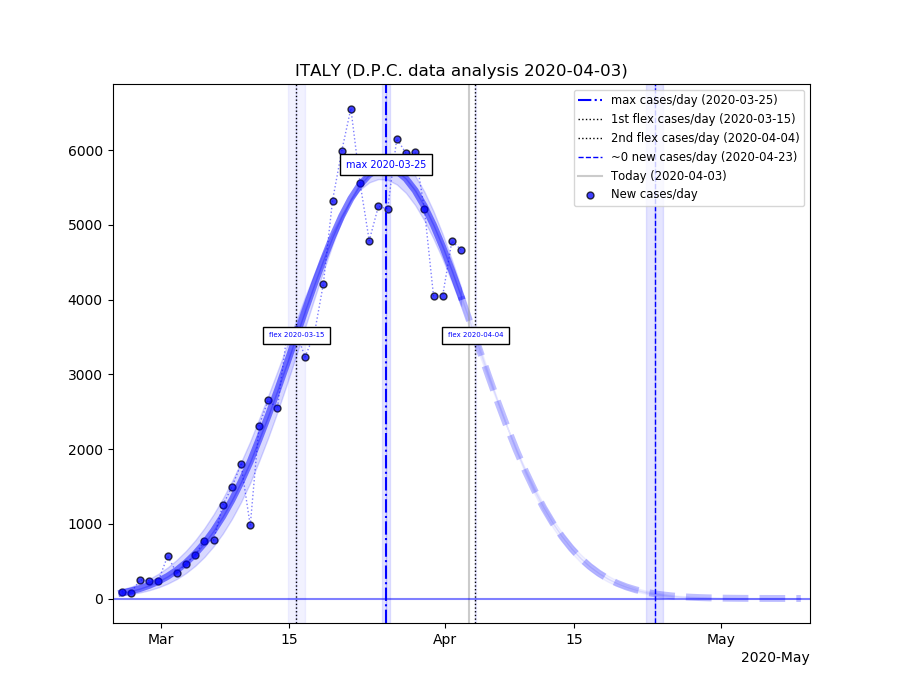

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), max(xg[-1], noC) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yC, alpha=0.75, c="b",edgecolors='#000000', marker="o", s=25, label="New cases/day")
# original data dotted line
ax.plot(x, yC, alpha=0.5, c="b", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yCg[:len(x)], alpha=0.5, c="b", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yCg[len(x) - 1:], alpha=0.25, c="b", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yCg[:len(x)], yCgSup[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], yCg[len(x) - 1:], yCgSup[len(x) - 1:], alpha=0.05, color="b")
ax.fill_between(xg[:len(x)], yCg[:len(x)], yCgInf[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], yCg[len(x) - 1:], yCgInf[len(x) - 1:], alpha=0.05, color="b")
# maximum and flexes
plt.axvline(x=muC, linestyle="-.", color="b", label="max cases/day ({})".format(muC.strftime("%Y-%m-%d")))
ax.axvspan(muC, muCsup, alpha=0.1, color="b")
ax.axvspan(muC, muCinf, alpha=0.1, color="b")
plt.text(muC, ymuC, "max " + muC.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")

plt.axvline(x=f1C, linestyle=":", color="k", label="1st flex cases/day ({})".format(f1C.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f1C, f1Csup, alpha=0.05, color="b")
ax.axvspan(f1C, f1Cinf, alpha=0.05, color="b")
plt.text(f1C, yf1C, "flex " + f1C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")

plt.axvline(x=f2C, linestyle=":", color="k", label="2nd flex cases/day ({})".format(f2C.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f2C, f2Csup, alpha=0.05, color="b")
ax.axvspan(f2C, f2Cinf, alpha=0.05, color="b")
plt.text(f2C, yf2C, "flex " + f2C.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="b")

# ~0 cases/day date vertical line 
plt.axvline(x=noC, color="b", linestyle="--", linewidth=1.0, label="~0 new cases/day ({})".format(noC.strftime("%Y-%m-%d")))
ax.axvspan(noC, noCsup, alpha=0.1, color="b")
ax.axvspan(noC, noCinf, alpha=0.1, color="b")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="b", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='small')
plt.show()

<IPython.core.display.Javascript object>


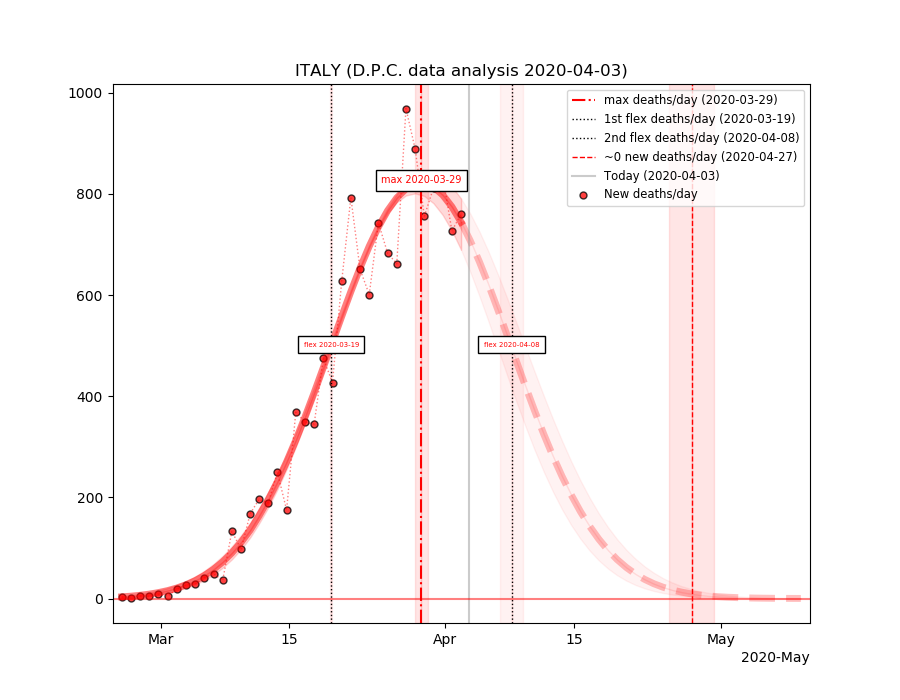

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlim(xg[0] - dt.timedelta(days=1), max(xg[-1], noD) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yD, alpha=0.75, c="r",edgecolors='#000000', marker="o", s=25, label="New deaths/day")
# original data dotted line
ax.plot(x, yD, alpha=0.5, c="r", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yDg[:len(x)], alpha=0.5, c="r", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yDg[len(x) - 1:], alpha=0.25, c="r", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yDg[:len(x)], yDgSup[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], yDg[len(x) - 1:], yDgSup[len(x) - 1:], alpha=0.05, color="r")
ax.fill_between(xg[:len(x)], yDg[:len(x)], yDgInf[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], yDg[len(x) - 1:], yDgInf[len(x) - 1:], alpha=0.05, color="r")
# maximum and flexes
plt.axvline(x=muD, linestyle="-.", color="r", label="max deaths/day ({})".format(muD.strftime("%Y-%m-%d")))
ax.axvspan(muD, muDsup, alpha=0.1, color="r")
ax.axvspan(muD, muDinf, alpha=0.1, color="r")
plt.text(muD, ymuD, "max " + muD.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")

plt.axvline(x=f1D, linestyle=":", color="k", label="1st flex deaths/day ({})".format(f1D.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f1D, f1Dsup, alpha=0.05, color="r")
ax.axvspan(f1D, f1Dinf, alpha=0.05, color="r")
plt.text(f1D, yf1D, "flex " + f1D.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")

plt.axvline(x=f2D, linestyle=":", color="k", label="2nd flex deaths/day ({})".format(f2D.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f2D, f2Dsup, alpha=0.05, color="r")
ax.axvspan(f2D, f2Dinf, alpha=0.05, color="r")
plt.text(f2D, yf2D, "flex " + f2D.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="r")

# ~0 deaths/day date vertical line 
plt.axvline(x=noD, color="r", linestyle="--", linewidth=1.0, label="~0 new deaths/day ({})".format(noD.strftime("%Y-%m-%d")))
ax.axvspan(noD, noDsup, alpha=0.1, color="r")
ax.axvspan(noD, noDinf, alpha=0.1, color="r")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="r", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='small')
plt.show()

<IPython.core.display.Javascript object>


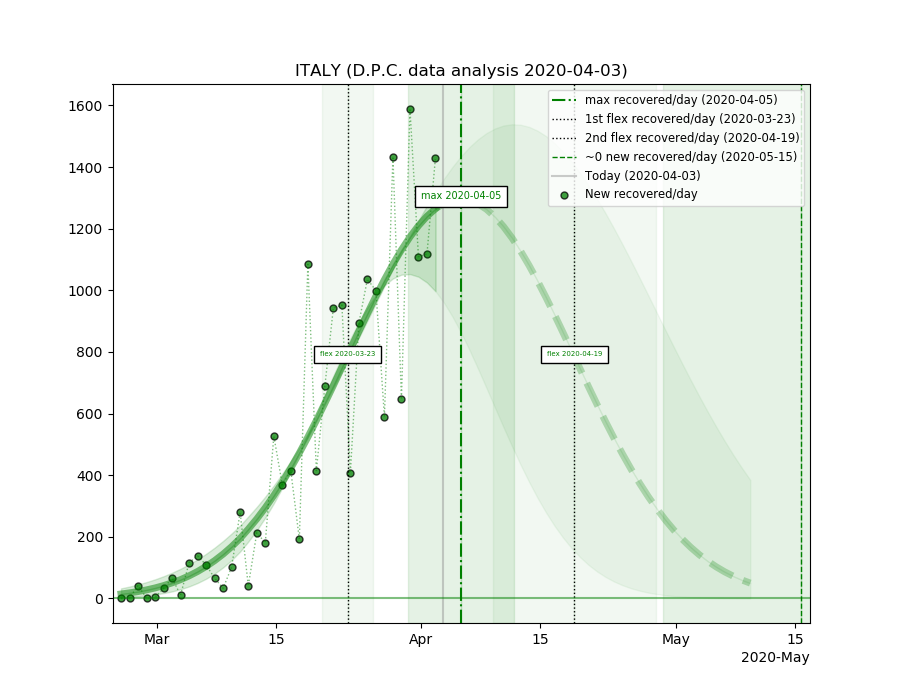

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlim(xg[0] - dt.timedelta(days=1), max(xg[-1], noR) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yR, alpha=0.75, c="g",edgecolors='#000000', marker="o", s=25, label="New recovered/day")
# original data dotted line
ax.plot(x, yR, alpha=0.5, c="g", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yRg[:len(x)], alpha=0.5, c="g", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yRg[len(x) - 1:], alpha=0.25, c="g", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yRg[:len(x)], yRgSup[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], yRg[len(x) - 1:], yRgSup[len(x) - 1:], alpha=0.05, color="g")
ax.fill_between(xg[:len(x)], yRg[:len(x)], yRgInf[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], yRg[len(x) - 1:], yRgInf[len(x) - 1:], alpha=0.05, color="g")
# maximum and flexes
plt.axvline(x=muR, linestyle="-.", color="g", label="max recovered/day ({})".format(muR.strftime("%Y-%m-%d")))
ax.axvspan(muR, muRsup, alpha=0.1, color="g")
ax.axvspan(muR, muRinf, alpha=0.1, color="g")
plt.text(muR, ymuR, "max " + muR.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")

plt.axvline(x=f1R, linestyle=":", color="k", label="1st flex recovered/day ({})".format(f1R.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f1R, f1Rsup, alpha=0.05, color="g")
ax.axvspan(f1R, f1Rinf, alpha=0.05, color="g")
plt.text(f1R, yf1R, "flex " + f1R.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")

plt.axvline(x=f2R, linestyle=":", color="k", label="2nd flex recovered/day ({})".format(f2R.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f2R, f2Rsup, alpha=0.05, color="g")
ax.axvspan(f2R, f2Rinf, alpha=0.05, color="g")
plt.text(f2R, yf2R, "flex " + f2R.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="g")

# ~0 recovered/day date vertical line 
plt.axvline(x=noR, color="g", linestyle="--", linewidth=1.0, label="~0 new recovered/day ({})".format(noR.strftime("%Y-%m-%d")))
ax.axvspan(noR, noRsup, alpha=0.1, color="g")
ax.axvspan(noR, noRinf, alpha=0.1, color="g")

# TORAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="g", alpha=0.5)

# LEGENR
plt.legend(loc='upper right', fontsize='small')
plt.show()

<IPython.core.display.Javascript object>


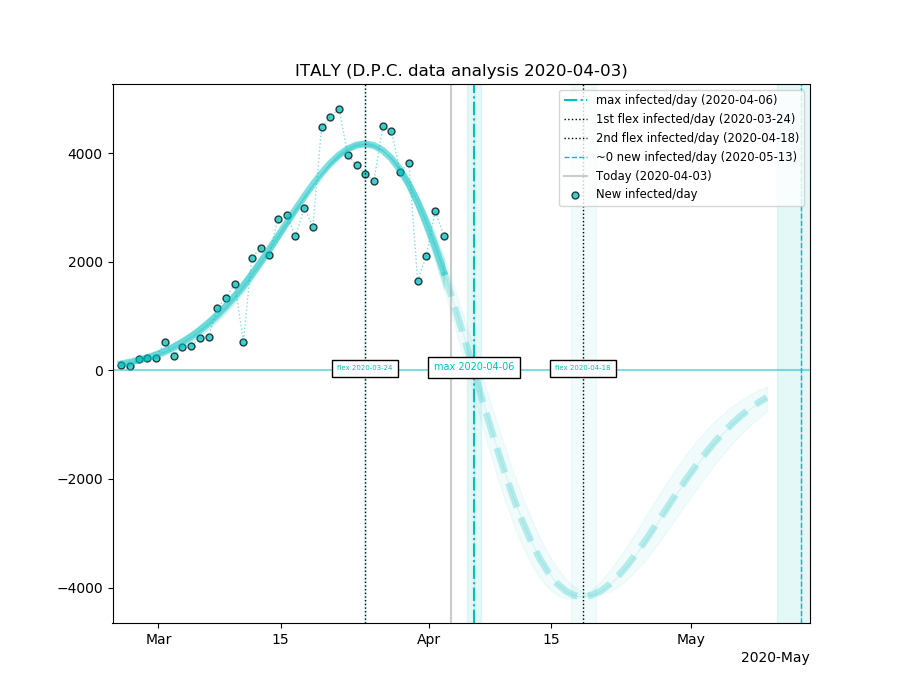

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlim(xg[0] - dt.timedelta(days=1), max(xg[-1], noP) + dt.timedelta(days=1))

# original data points
ax.scatter(x, yP, alpha=0.75, c="c",edgecolors='#000000', marker="o", s=25, label="New infected/day")
# original data dotted line
ax.plot(x, yP, alpha=0.5, c="c", linestyle=":", linewidth=1.0)
# gaussian fitted curve up to forecast limit
ax.plot(xg[:len(x)], yPg[:len(x)], alpha=0.5, c="c", linestyle="-", linewidth=5.0)
ax.plot(xg[len(x) - 1:], yPg[len(x) - 1:], alpha=0.25, c="c", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yPg[:len(x)], yPgSup[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], yPg[len(x) - 1:], yPgSup[len(x) - 1:], alpha=0.05, color="c")
ax.fill_between(xg[:len(x)], yPg[:len(x)], yPgInf[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], yPg[len(x) - 1:], yPgInf[len(x) - 1:], alpha=0.05, color="c")
# maximum and flexes
plt.axvline(x=muP, linestyle="-.", color="c", label="max infected/day ({})".format(muP.strftime("%Y-%m-%d")))
ax.axvspan(muP, muPsup, alpha=0.1, color="c")
ax.axvspan(muP, muPinf, alpha=0.1, color="c")
plt.text(muP, 0, "max " + muP.strftime("%Y-%m-%d"), fontsize=7, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="c")

plt.axvline(x=f1P, linestyle=":", color="k", label="1st flex infected/day ({})".format(f1P.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f1P, f1Psup, alpha=0.05, color="c")
ax.axvspan(f1P, f1Pinf, alpha=0.05, color="c")
plt.text(f1P, 0, "flex " + f1P.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="c")

plt.axvline(x=f2P, linestyle=":", color="k", label="2nd flex infected/day ({})".format(f2P.strftime("%Y-%m-%d")), linewidth=1.0)
ax.axvspan(f2P, f2Psup, alpha=0.05, color="c")
ax.axvspan(f2P, f2Pinf, alpha=0.05, color="c")
plt.text(f2P, 0, "flex " + f2P.strftime("%Y-%m-%d"), fontsize=5, horizontalalignment='center', bbox=dict(facecolor='w', alpha=1), color="c")

# ~0 infected/day date vertical line 
plt.axvline(x=noP, color="c", linestyle="--", linewidth=1.0, label="~0 new infected/day ({})".format(noP.strftime("%Y-%m-%d")))
ax.axvspan(noP, noPsup, alpha=0.1, color="c")
ax.axvspan(noP, noPinf, alpha=0.1, color="c")

# TOPAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="c", alpha=0.5)

# LEGENP
plt.legend(loc='upper right', fontsize='small')
plt.show()

And finally look to the complete result, hiding original data and flexes

<IPython.core.display.Javascript object>


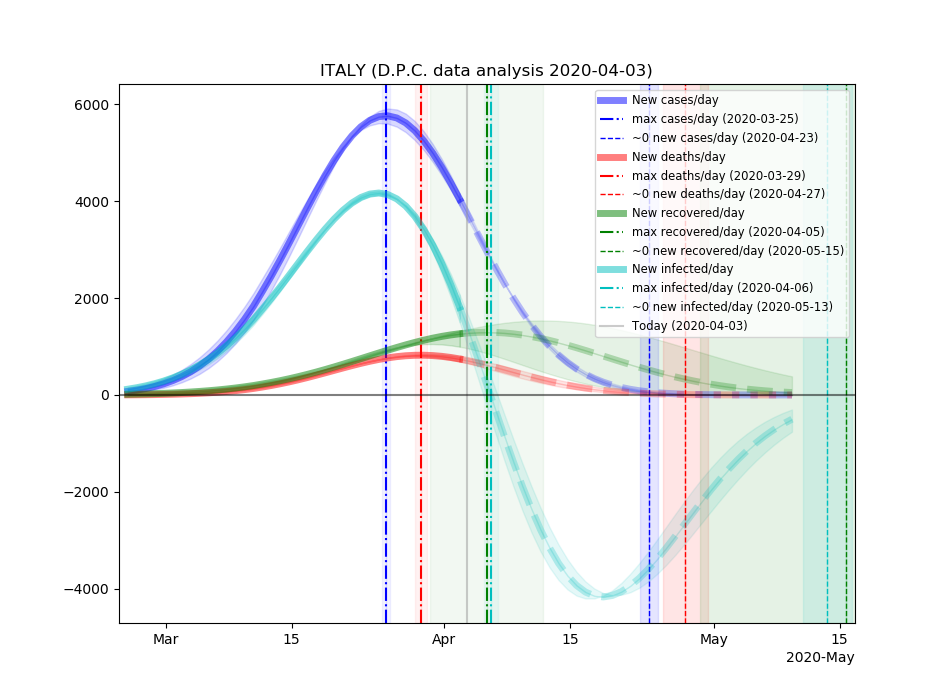

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9.5, 7])
plt.title("ITALY (D.P.C. data analysis {})".format(dt.datetime.now().strftime("%Y-%m-%d")))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlim(xg[0] - dt.timedelta(days=1), max(xg[-1], noC, noD, noR, noP) + dt.timedelta(days=1))

# CONFIRMED
ax.plot(xg[:len(x)], yCg[:len(x)], alpha=0.5, c="b", linestyle="-", linewidth=5.0, label="New cases/day")
ax.plot(xg[len(x) - 1:], yCg[len(x) - 1:], alpha=0.25, c="b", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yCg[:len(x)], yCgSup[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], yCg[len(x) - 1:], yCgSup[len(x) - 1:], alpha=0.1, color="b")
ax.fill_between(xg[:len(x)], yCg[:len(x)], yCgInf[:len(x)], alpha=0.15, color="b")
ax.fill_between(xg[len(x) - 1:], yCg[len(x) - 1:], yCgInf[len(x) - 1:], alpha=0.1, color="b")
plt.axvline(x=muC, linestyle="-.", color="b", label="max cases/day ({})".format(muC.strftime("%Y-%m-%d")))
ax.axvspan(muC, muCsup, alpha=0.05, color="b")
ax.axvspan(muC, muCinf, alpha=0.05, color="b")
plt.axvline(x=noC, color="b", linestyle="--", linewidth=1.0, label="~0 new cases/day ({})".format(noC.strftime("%Y-%m-%d")))
ax.axvspan(noC, noCsup, alpha=0.1, color="b")
ax.axvspan(noC, noCinf, alpha=0.1, color="b")

# DEATHS
ax.plot(xg[:len(x)], yDg[:len(x)], alpha=0.5, c="r", linestyle="-", linewidth=5.0, label="New deaths/day")
ax.plot(xg[len(x) - 1:], yDg[len(x) - 1:], alpha=0.25, c="r", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yDg[:len(x)], yDgSup[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], yDg[len(x) - 1:], yDgSup[len(x) - 1:], alpha=0.1, color="r")
ax.fill_between(xg[:len(x)], yDg[:len(x)], yDgInf[:len(x)], alpha=0.15, color="r")
ax.fill_between(xg[len(x) - 1:], yDg[len(x) - 1:], yDgInf[len(x) - 1:], alpha=0.1, color="r")
plt.axvline(x=muD, linestyle="-.", color="r", label="max deaths/day ({})".format(muD.strftime("%Y-%m-%d")))
ax.axvspan(muD, muDsup, alpha=0.05, color="r")
ax.axvspan(muD, muDinf, alpha=0.05, color="r")
plt.axvline(x=noD, color="r", linestyle="--", linewidth=1.0, label="~0 new deaths/day ({})".format(noD.strftime("%Y-%m-%d")))
ax.axvspan(noD, noDsup, alpha=0.1, color="r")
ax.axvspan(noD, noDinf, alpha=0.1, color="r")

# RECOVERED
ax.plot(xg[:len(x)], yRg[:len(x)], alpha=0.5, c="g", linestyle="-", linewidth=5.0, label="New recovered/day")
ax.plot(xg[len(x) - 1:], yRg[len(x) - 1:], alpha=0.25, c="g", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yRg[:len(x)], yRgSup[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], yRg[len(x) - 1:], yRgSup[len(x) - 1:], alpha=0.1, color="g")
ax.fill_between(xg[:len(x)], yRg[:len(x)], yRgInf[:len(x)], alpha=0.15, color="g")
ax.fill_between(xg[len(x) - 1:], yRg[len(x) - 1:], yRgInf[len(x) - 1:], alpha=0.1, color="g")
plt.axvline(x=muR, linestyle="-.", color="g", label="max recovered/day ({})".format(muR.strftime("%Y-%m-%d")))
ax.axvspan(muR, muRsup, alpha=0.05, color="g")
ax.axvspan(muR, muRinf, alpha=0.05, color="g")
plt.axvline(x=noR, color="g", linestyle="--", linewidth=1.0, label="~0 new recovered/day ({})".format(noR.strftime("%Y-%m-%d")))
ax.axvspan(noR, noRsup, alpha=0.1, color="g")
ax.axvspan(noR, noRinf, alpha=0.1, color="g")

# INFECTED
ax.plot(xg[:len(x)], yPg[:len(x)], alpha=0.5, c="c", linestyle="-", linewidth=5.0, label="New infected/day")
ax.plot(xg[len(x) - 1:], yPg[len(x) - 1:], alpha=0.25, c="c", linestyle="--", linewidth=5.0)
ax.fill_between(xg[:len(x)], yPg[:len(x)], yPgSup[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], yPg[len(x) - 1:], yPgSup[len(x) - 1:], alpha=0.1, color="c")
ax.fill_between(xg[:len(x)], yPg[:len(x)], yPgInf[:len(x)], alpha=0.15, color="c")
ax.fill_between(xg[len(x) - 1:], yPg[len(x) - 1:], yPgInf[len(x) - 1:], alpha=0.1, color="c")
plt.axvline(x=muP, linestyle="-.", color="c", label="max infected/day ({})".format(muP.strftime("%Y-%m-%d")))
ax.axvspan(muP, muPsup, alpha=0.05, color="c")
ax.axvspan(muP, muPinf, alpha=0.05, color="c")
plt.axvline(x=noP, color="c", linestyle="--", linewidth=1.0, label="~0 new infected/day ({})".format(noP.strftime("%Y-%m-%d")))
ax.axvspan(noP, noPsup, alpha=0.1, color="c")
ax.axvspan(noP, noPinf, alpha=0.1, color="c")

# TODAY date grey vertical line
plt.axvline(x=dt.datetime.now(), color="#999999", alpha=0.5, linestyle="-", label="Today ({})".format(dt.datetime.now().strftime("%Y-%m-%d")))
plt.axhline(y=0, color="k", alpha=0.5)

# LEGEND
plt.legend(loc='upper right', fontsize='small')
plt.show()